# Task 3. Algorithms of unconditional nonlinear optimization. First and second order methods

### Generate random numbers $\alpha \in (0, 1)$  and $\beta \in (0, 1)$. Furthermore, generate the noisy data {$x_k, y_k$}, where $k = 0, 1, .. 100$, according to the rule: $x_k = \frac{k}{100}$, ${y_k = \alpha x_k + \beta + \delta_k}$, where $\delta_k \sim N(0, 1)$ are values of a random variable with standard normal distribution. Approximate the data by the following linear and rational functions:

### $1) F(x, a, b) = ax + b$ (linear approximant)
### $2) F(x, a, b) = \frac{a}{1 + bx}$ (rational approximant)

### by means of least squares through the numerical minimization (with precision $\varepsilon = 0.001$) of the following function:

### $D(a, b) = \sum \limits_{k = 0}^{100} (F(x_k, a, b) - y_k)^2 $

### To solve the minimization problem, use gradient descent,the conjugate gradient method, the Newton method and the Levenberg-Marquardt algorithm. If necessary, set the initial approximations and other parameters of the methods yourself. 

### On the graph (separately for each approximating function), draw an array of generateddata and graphs of approximating functions obtained using these numerical optimization algorithms. Analyzethe results obtained in terms of the number of iterations performed. Compare the results obtained with the results from previous task


In [206]:
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize, minimize_scalar

global x_arr
global y_arr


def linear_approx(x, args):
    return args[0] * x + args[1]


def rational_approx(x, args):
    return args[0] / (1 + args[1] * x)


def least_squares_linear(args):
    return np.sum(np.square(args[0] * x_arr + args[1] - y_arr))


def least_squares_rational(args):
    return np.sum(np.square(args[0] / (1 + args[1] * x_arr) - y_arr))


def gradient_scipy(func, args, eps = 1e-4):
    
    a_arg, b_arg = args[0], args[1]

    part_deriv_a = misc.derivative(lambda a: func([a, b_arg]), a_arg, dx = eps)
    part_deriv_b = misc.derivative(lambda b: func([a_arg, b]), b_arg, dx = eps)

    return np.array(part_deriv_a, part_deriv_b)


def gradient_num(func, args, eps = 1e-4):
    
    a_arg, b_arg = args[0], args[1]
    
    part_deriv_a = (func([a_arg + eps, b_arg]) - func([a_arg - eps, b_arg])) / (2 * eps)
    part_deriv_b = (func([a_arg, b_arg + eps]) - func([a_arg, b_arg - eps])) / (2 * eps)

    return np.array([part_deriv_a,  part_deriv_b])


def hessian_num(func, args, eps = 1e-4):
    
    a_arg, b_arg = args[0], args[1]
    
    func_ab = func([a_arg, b_arg])
    func_a_eps_b = func([a_arg + eps, b_arg])
    func_a_b_eps = func([a_arg, b_arg + eps])

    part_deriv_aa = (func_a_eps_b - 2 * func_ab + func([a_arg - eps, b_arg])) / (eps ** 2)
    part_deriv_bb = (func_a_b_eps - 2 * func_ab + func([a_arg, b_arg - eps])) / (eps ** 2)
    part_deriv_ab = (func([a_arg + eps, b_arg + eps]) - func_a_eps_b - func_a_b_eps + func_ab) / (eps ** 2)
    
    return np.array([[part_deriv_aa, part_deriv_ab], [part_deriv_ab, part_deriv_bb]])


def gradient_descent(func, initial_approx = [1, 0], eps = 1e-3):
    
    func_eval_num, iter_num = 0, 0
    args_prev = np.array(initial_approx)
    grad_func_prev = gradient_num(func, args_prev)

    res = minimize_scalar(lambda x: func(args_prev - x * grad_func_prev))
    args_curr = args_prev - np.dot(grad_func_prev, res.x)
    grad_func_curr = gradient_num(func, args_curr)
    
    func_eval_num += res.nfev + 8
    iter_num += 1
    
    while (np.linalg.norm(args_curr - args_prev, np.inf) >= eps) and (iter_num < 1000):
        
        beta = np.dot(args_curr - args_prev, grad_func_curr - grad_func_prev) \
        / np.square(np.linalg.norm(grad_func_curr - grad_func_prev))
        
        args_prev = args_curr
        grad_func_prev = grad_func_curr
        
        args_curr = args_prev - np.dot(grad_func_prev, beta)
        grad_func_curr = gradient_num(func, args_curr)

        #cond = abs(func(args_curr) - func(args_prev))
        #print(args_curr[0], args_curr[1], cond) 
        #plt.scatter(args_curr[0], args_curr[1])
        
        func_eval_num += 4
        iter_num += 1
    
    n_digits = abs(int(round(np.log10(eps))))

    return np.array([round(args_curr[0], n_digits), round(args_curr[1], n_digits), func_eval_num, iter_num])


def conjugate_gradient_descent(func, initial_approx = [1, 0], eps = 1e-3):
    
    func_eval_num, iter_num = 0, 0
    args_prev = np.array(initial_approx)
    grad_func_prev = gradient_num(func, args_prev)

    res = minimize_scalar(lambda x: func(args_prev - x * grad_func_prev))
    args_curr = args_prev - np.dot(grad_func_prev, res.x)
    grad_func_curr = gradient_num(func, args_curr)
    
    conj_direction = -1 * grad_func_prev
    
    func_eval_num += res.nfev + 8
    iter_num += 1
    
    while (np.linalg.norm(args_curr - args_prev, np.inf) >= eps) and (iter_num < 1000):
        
        beta = np.dot(grad_func_curr, grad_func_curr) / np.dot(grad_func_prev, grad_func_prev)
        #beta = np.dot(grad_func_curr, grad_func_curr - grad_func_prev) / np.dot(grad_func_prev, grad_func_prev)
        
        conj_direction = np.dot(beta, conj_direction) - grad_func_curr
        
        args_prev = args_curr
        grad_func_prev = grad_func_curr

        res = minimize_scalar(lambda x: func(args_prev + x * conj_direction))
        args_curr = args_prev + np.dot(conj_direction, res.x)
        grad_func_curr = gradient_num(func, args_curr)

        #cond = abs(func(args_curr) - func(args_prev))
        #print(args_curr[0], args_curr[1], cond) 
        #plt.scatter(args_curr[0], args_curr[1])
        
        func_eval_num += res.nfev + 4
        iter_num += 1
    
    n_digits = abs(int(round(np.log10(eps))))

    return np.array([round(args_curr[0], n_digits), round(args_curr[1], n_digits), int(func_eval_num), int(iter_num)])


def Newtons_method(func, initial_approx = [1, 0], eps = 1e-3):
    
    res = minimize(func, initial_approx, method = 'Newton-CG', jac = (lambda x: gradient_num(func, x)), \
                   hess = (lambda x: hessian_num(func, x)), options = {'xtol': eps})
    n_digits = abs(int(round(np.log10(eps))))

    return np.array([round(res.x[0], n_digits), round(res.x[1], n_digits), res.nfev, res.nit])
                   
                   
def Levenberg_Marquardt(approx_fun, initial_aprox = [1, 0], eps = 1e-3):
    
    reg_param = 0.1
    func_eval_num, iter_num = 0, 0
    args_prev = np.array(initial_aprox)
        
    jac = np.array([gradient_num(lambda args: approx_fun(x_i, args), args_prev)for x_i in x_arr])
    inv_cond = np.linalg.inv(np.dot(jac.T, jac) + reg_param * np.diag(np.dot(jac.T, jac)) * np.eye(2))
        
    delta_arg = np.dot(inv_cond, np.dot(jac.T, y_arr - np.array([approx_fun(x_i, args_prev) for x_i in x_arr])))
    args_curr = args_prev + delta_arg
    
    #cond = abs(func(args_curr) - func(args_prev))
    #print(args_curr[0], args_curr[1], cond) 
    #plt.scatter(args_curr[0], args_curr[1])
    
    while (np.linalg.norm(args_curr - args_prev, np.inf) >= eps) and (iter_num < 1000):
        
        args_prev = args_curr
        
        jac = np.array([gradient_num(lambda args: approx_fun(x_i, args), args_prev)for x_i in x_arr])
        inv_cond = np.linalg.inv(np.dot(jac.T, jac) + reg_param * np.diag(np.dot(jac.T, jac)) * np.eye(2))
        delta_arg = np.dot(inv_cond, np.dot(jac.T, y_arr - np.array([approx_fun(x_i, args_prev) for x_i in x_arr])))
        
        args_curr = args_prev + delta_arg
        
        #cond = abs(func(args_curr) - func(args_prev))
        #print(args_curr[0], args_curr[1], cond) 
        #plt.scatter(args_curr[0], args_curr[1])
        
        func_eval_num += 1
        iter_num += 1
    
    n_digits = abs(int(round(np.log10(eps))))

    return np.array([round(args_curr[0], n_digits), round(args_curr[1], n_digits), func_eval_num, iter_num])


# TESTING ---------------------------------------------------------------------------------------

# Data from previous lab: (x_arr, y_arr) = {x_k, y_k}, k in [0, 100]:
x_arr = np.load('x_arr.npy')
y_arr = np.load('y_arr.npy')

# df_lin ans df_rat - DataFrame wirh resultd for linear and rational approximations, respectively:
df_lin = pd.read_csv('Linear_approx_lab_2.csv', index_col = 0)
df_rat = pd.read_csv('Rational_approx_lab_2.csv', index_col = 0)

# Recording the results in the same dataframes, respectively:
algos_dict = {'gradient descent method': gradient_descent, 'conjugate gradient descent method': conjugate_gradient_descent, \
              "Newton's method": Newtons_method, 'Levenberg-Marquardt alghorithm': Levenberg_Marquardt}

for alg_name in list(algos_dict.keys())[:-1]:
    
    df_lin[alg_name] = algos_dict[alg_name](least_squares_linear)
    df_rat[alg_name] = algos_dict[alg_name](least_squares_rational)
    
alg_name = list(algos_dict.keys())[-1]
df_lin[alg_name] = algos_dict[alg_name](linear_approx)
df_rat[alg_name] = algos_dict[alg_name](rational_approx)
    
df_lin

,exhaustive search,coordinate descent method,Nelder Mead method,gradient descent method,conjugate gradient descent method,Newton's method,Levenberg-Marquardt alghorithm
a,0.451,0.451,0.451,0.451,0.451,0.451,0.451
b,0.965,0.964,0.965,0.965,0.965,0.965,0.965
nfev,7834402.000,1744.000,104.000,41.000,77.000,4.000,8.000
nit,7834402.000,150.000,53.000,7.000,3.000,3.000,8.000


In [207]:
df_rat

,exhaustive search,coordinate descent method,Nelder Mead method,gradient descent method,conjugate gradient descent method,Newton's method,Levenberg-Marquardt alghorithm
a,1.012,1.011,1.012,1.011,1.010,1.008,1.012
b,-0.285,-0.285,-0.285,-0.286,-0.287,-0.289,-0.285
nfev,7834402.000,3528.000,129.000,57.000,117.000,6.000,4.000
nit,7834402.000,229.000,68.000,7.000,4.000,5.000,4.000


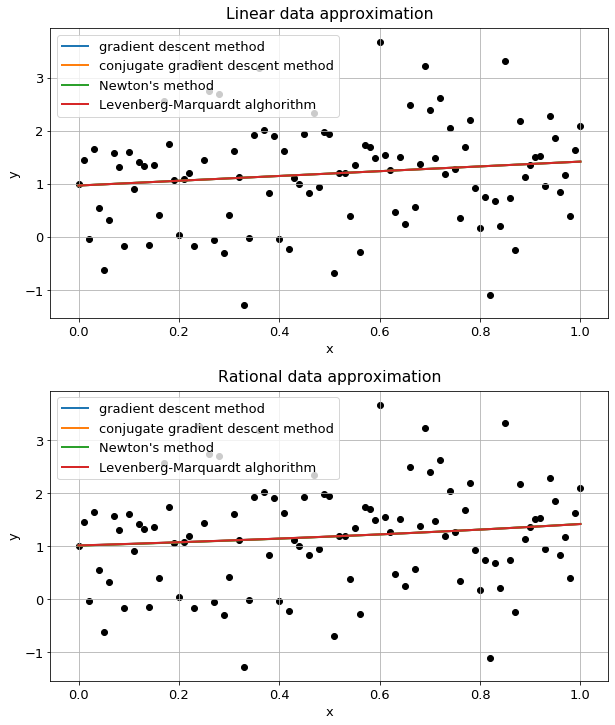

In [218]:
# Vizualization - as it should be

start_alg = 3
stop_alg = 7

fig, ax = plt.subplots(figsize = (10, 12))
plt.subplots_adjust(wspace = 0.25, hspace = 0.25)

plt.subplot(2, 1, 1)
plt.scatter(x_arr, y_arr, c = 'k')

for i in range(start_alg, stop_alg):
    
    a_lin, b_lin = round(df_lin[df_lin.columns[i]]['a'], 3), round(df_lin[df_lin.columns[i]]['b'], 3)
    plt.plot(x_arr, a_lin * x_arr + b_lin, linewidth = 2)

plt.title('Linear data approximation', pad = 10)
plt.legend(list(algos_dict.keys()), loc = 'upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()


plt.subplot(2, 1, 2)
plt.scatter(x_arr, y_arr, c = 'k')

for i in range(start_alg, stop_alg):
    
    a_rat, b_rat = round(df_rat[df_rat.columns[i]]['a'], 3), round(df_rat[df_rat.columns[i]]['b'], 3)
    plt.plot(x_arr, a_rat / (1 + x_arr * b_rat), linewidth = 2)

plt.title('Rational data approximation', pad = 10)
plt.legend(list(algos_dict.keys()), loc = 'upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

plt.show()
fig.savefig('approx_result.png')

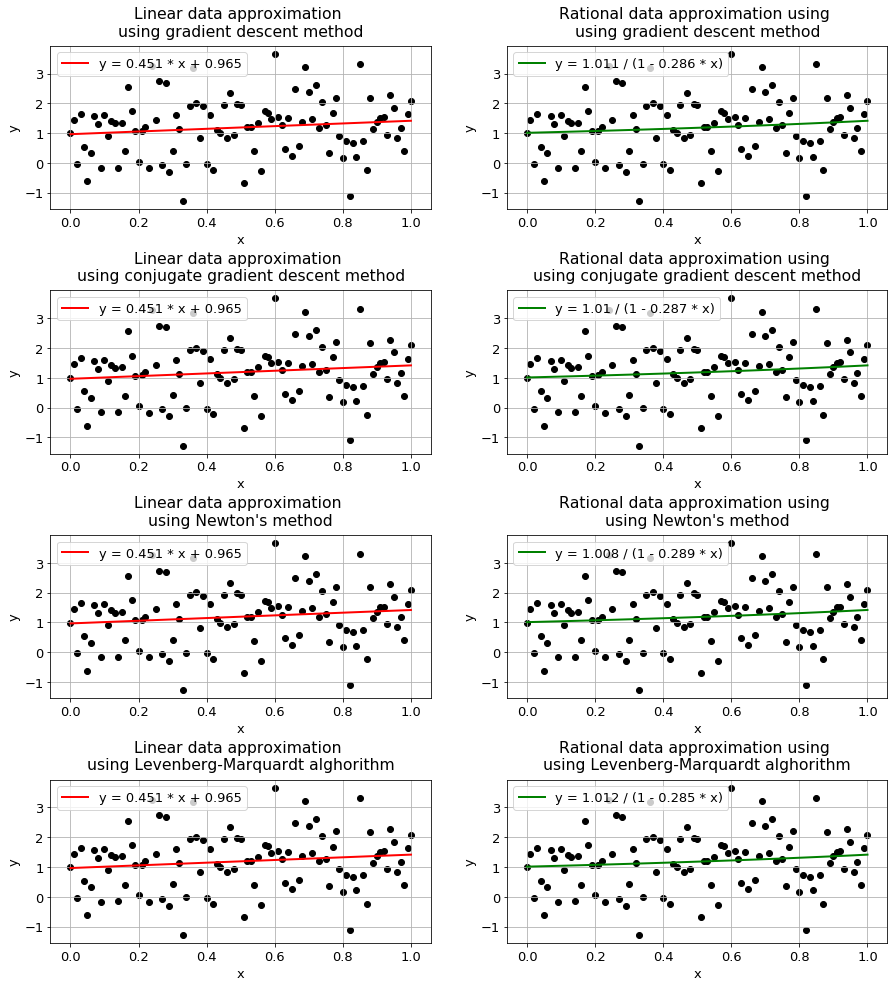

In [220]:
# Vizualization - as it should be

fig, ax = plt.subplots(figsize = (15, 30))
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

for i in range (3, 7):
    
    a_lin, b_lin = round(df_lin[df_lin.columns[i]]['a'], 3), round(df_lin[df_lin.columns[i]]['b'], 3)
    a_rat, b_rat = round(df_rat[df_rat.columns[i]]['a'], 3), round(df_rat[df_rat.columns[i]]['b'], 3)

    plt.subplot(7, 2, 2 * i + 1)
    plt.scatter(x_arr, y_arr, c = 'k')
    plt.plot(x_arr, a_lin * x_arr + b_lin, c = 'r', linewidth = 2)

    plt.title('Linear data approximation \n' + 'using ' + df_lin.columns[i], pad = 10)
    plt.legend(['y = {0} * x + {1}'.format(a_lin, b_lin)], loc = 'upper left')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()

    plt.subplot(7, 2, 2 * i + 2)
    plt.scatter(x_arr, y_arr, c = 'k')
    plt.plot(x_arr, a_rat / (1 + x_arr * b_rat), c = 'g', linewidth = 2)

    plt.title('Rational data approximation using \n' + 'using ' + df_lin.columns[i], pad = 10)
    plt.legend(['y = {0} / (1 - {1} * x)'.format(a_rat, abs(b_rat))], loc = 'upper left')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()

plt.show()
fig.savefig('approx_result.png')